In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import panel as pn
import seaborn as sn
import hvplot.pandas

In [2]:
pn.extension('vega', 'tabulator')

# Data

In [3]:
sales_store = pd.read_csv("./data/Sales_store.csv")
sales_trans =pd.read_csv("./data/Sales_train.csv")

/tmp/ipykernel_7487/3249710734.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_trans =pd.read_csv("./data/Sales_train.csv")


In [4]:
sales_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


* Store: identificador único de la tienda
* StoreType: categoría que indica el tipo de tienda (a, b, c, d)
* Assortment:  a = básico, b = extra, c = extedido
* CompetitionDistance (en metros): distancia a la tienda de la competencia más cercana
* CompetitionOpenSince [Mes/Año]:  fecha en que abrió la competencia
* Promo2: Promo2 es una promoción continuada y consecutiva en algunas tiendas (0 = la tienda no participa, 1 = la tienda participa)
* Promo2Since [Año/Semana]: fecha en la que la tienda empieza a participar en la Promo2
* PromoInterval: describe los intervalos consecutivos donde la Promo2 empieza, indicando los meses en los que empieza la misma. P.e. "Feb,May,Aug,Nov" significa que cada nueva ronda de promoción empieza en Febrero, Mayo, Agosto, Noviembre de cualquier año de esa tienda

In [5]:
sales_store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [6]:
sales_store.head(3)

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct

In [7]:
sales_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


* Id:  ID de transacción (combinación de la tienda y la fecha)
* Sales: ventas diarias, esta es la variable objetivo
* Customers: número de clientes de un día dado
* Open: Booleano para indicar si la tienda estaba abierta o cerrada (0 = cerrada, 1 = abierta)
* Promo: describe si la tienda tenía algún tipo de promoción ese día o no
* StateHoliday: indica si el día era festivo o no (a = vacaciones públicas, b = vacaciones de Pascua, c = Navidades, 0 = No era festivo)
* SchoolHoliday: indica si (Store, Date) se ve afectado por el cierre de las escuelas públicas
* Fuente original de los datos: https://www.kaggle.com/c/rossmann-store-sales/data


In [8]:
sales_trans.head(3)

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1

In [9]:
sales_trans['Date'] = pd.to_datetime(sales_trans['Date'])
sales_trans['day'] = sales_trans['Date'].dt.day
sales_trans['month'] = sales_trans['Date'].dt.month
sales_trans['year'] = sales_trans['Date'].dt.year
sales_trans.sort_values(by='Date', inplace = True)
#sales_trans["counter"] = np.arange(len(sales_trans))

In [10]:
#df.describe()

In [11]:
sales_trans.head(3)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
1017208   1115          2 2013-01-01      0          0     0      0   
1016473    379          2 2013-01-01      0          0     0      0   
1016472    378          2 2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  day  month  year  
1017208            a              1    1      1  2013  
1016473            a              1    1      1  2013  
1016472            a              1    1      1  2013

# EDA

### Clean data

In [12]:
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
#sn.heatmap(sales_trans.isnull(), yticklabels=False, cbar=False, cmap="Blues", ax=axs[0] )
#sn.heatmap(sales_store.isnull(), yticklabels=False, cbar=False, cmap="Blues", ax=axs[1] )

In [13]:
# whithout promo then there are not days of promo
sales_store.isnull().sum() 
# 544 + 571 = 1115

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [14]:
for col in ["Promo2SinceWeek","Promo2SinceYear", "PromoInterval"]:
    sales_store[col].fillna(0, inplace=True)

In [15]:
sales_store.isnull().sum() 

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

<Axes: >

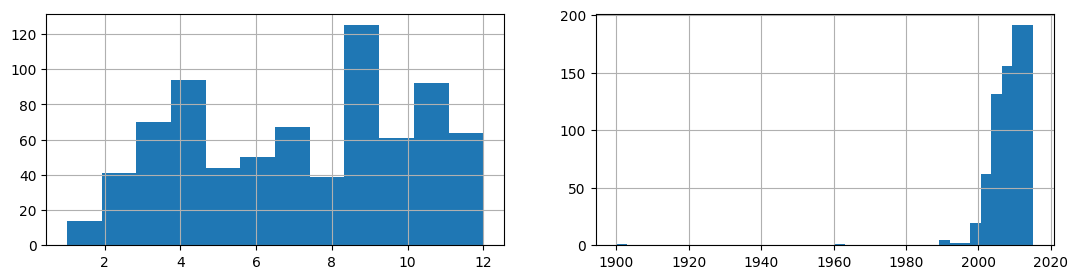

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,3))
sales_store["CompetitionOpenSinceMonth"].hist(bins=12, ax=axs[0])
sales_store["CompetitionOpenSinceYear"].hist(bins=40, ax=axs[1])

In [17]:
moths = ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]
values = [np.random.choice(np.arange(1,12,1),354), np.random.choice(np.arange(2000,2020,1),354)]
for col,value in zip(moths, values) :
    bool_null = sales_store[col].isnull()
    sales_store.loc[ bool_null, col] = value

In [18]:
sales_store["CompetitionDistance"].fillna( sales_store.CompetitionDistance.mean(), inplace=True )

In [19]:
sales_store.isnull().sum() 

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [20]:
df = pd.merge(sales_trans, sales_store, how = 'inner', on = 'Store')
df.to_csv('./data/sales_data_clear.csv', index = False)

In [21]:
del sales_store, sales_trans

## Simple Dashboard

### Stores analysis

In [74]:
df.head(3)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0   1115          2 2013-01-01      0          0     0      0            a   
1   1115          3 2013-01-02   3697        305     1      0            0   
2   1115          4 2013-01-03   4297        300     1      0            0   

   SchoolHoliday  day  ...  year  StoreType Assortment CompetitionDistance  \
0              1    1  ...  2013          d          c              5350.0   
1              1    2  ...  2013          d          c              5350.0   
2              1    3  ...  2013          d          c              5350.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        3.0                    2015.0       1   
1                        3.0                    2015.0       1   
2                        3.0                    2015.0       1   

   Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0             22.0           2012.0  Mar,Jun,Sept,Dec  
1             22.0           2012.0  Mar,Jun,Sept,Dec  
2             22.0           2012.0  Mar,Jun,Sept,Dec  

[3 rows x 21 columns]

In [55]:
choice_store = pn.widgets.MultiChoice(name='Stores', value=[1,2],
                                      options=list(df.Store.unique()))
choice_store

MultiChoice(name='Stores', options=[1115, 379, 378, ...], value=[1, 2])

In [56]:
choice_month = pn.widgets.MultiChoice(name='Months', value=[1,2,3,4,5,6,7,8,9,10,11,12],
                                      options=list(df.month.unique()))
choice_month

MultiChoice(name='Months', options=[1, 2, 3, 4, 5, ...], value=[1, 2, 3, 4, 5, ...])

In [54]:
button_DayOfWeek = pn.widgets.CheckButtonGroup(name='Day of Week', 
                                              value=[1],
                                              options=list(df.DayOfWeek.unique())
                                             )
button_DayOfWeek

CheckButtonGroup(name='Day of Week', options=[2, 3, 4, 5, 6, 7, 1], value=[1])

In [36]:
choice_store

MultiChoice(name='Stores', options=[1115, 379, 378, ...], value=[2])

In [62]:
text = """
#  Stores Analysis 
Show trends in the number of customers and clients 
by days of the week and months.
"""

In [75]:
def filter_data(st=[1,2],da=[1],mo=[1,2,3,4,5,6,7,8,9,10,11,12]):
    a = df[ (df.Store.isin( st )) & (df.DayOfWeek.isin( da )) & (df.month.isin( mo )) ]
    a = a.hvplot.scatter( x="Date", y="Customers", by="Store" ,  width=480, height=400)
    b = df[ (df.Store.isin( st )) & (df.DayOfWeek.isin( da )) & (df.month.isin( mo )) ]
    b = b.hvplot.scatter( x="Date", y="Sales", by="Store" ,  width=480, height=400)
    return a+b

stores_chart = pn.Row(pn.Column(pn.pane.Markdown(text, margin=(0, 10)),
                                pn.WidgetBox(pn.widgets.StaticText(name="", value='Days'),
                                             button_DayOfWeek, choice_month, choice_store)),
                      filter_data())

def update_chart(event):
    stores_chart[1].object = filter_data(choice_store.value,button_DayOfWeek.value,choice_month.value) 

button_DayOfWeek.param.watch(update_chart, "value")
choice_store.param.watch(update_chart, "value")
choice_month.param.watch(update_chart, "value")

stores_chart.servable()

Row
    [0] Column
        [0] Markdown(str, margin=(0, 10))
        [1] WidgetBox
            [0] StaticText(value='Days')
            [1] CheckButtonGroup(name='Day of Week', options=[2, 3, 4, 5, 6, 7, 1], value=[1])
            [2] MultiChoice(name='Months', options=[1, 2, 3, 4, 5, ...], value=[1, 2, 3, 4, 5, ...])
            [3] MultiChoice(name='Stores', options=[1115, 379, 378, ...], value=[1, 2])
    [1] HoloViews(Layout)

### Overview Analysis

## Predictions